# Phase 1: Enhanced Behavioral Clustering (Complete Analysis)

**Goal**: Identify behavioral clusters of the **18 Selected Parks** using Real-time Place Data.
**Process**:
1. Data Loading & Filtering (18 Parks)
2. Comprehensive Feature Engineering
3. Correlation Analysis (Heatmap)
4. Optimal K Determination (Elbow Method & Silhouette Score)
5. Hierarchical Clustering Visualization (Dendrogram)
6. Final Clustering (K=5)
7. Cluster Interpretation & Profiling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. Load & Filter Data (Target 18 Parks)

In [3]:
from live_population_data_import import load_live_population_data

df = load_live_population_data()

# --- FILTERING STEP ---
target_parks = [
    "Banpo Hangang Park", "Children's Grand Park", "Dream Forest",
    "Gangseo Hangang Park", "Gwangnaru Hangang Park", "Ichon Hangang Park",
    "Jamsil Hangang Park", "Jamwon Hangang Park", "Mangwon Hangang Park",
    "Namsan Park", "Nanji Hangang Park", "Seoul Forest", "Seoul Grand Park",
    "The National Museum of Korea·Yongsan Family Park", "Ttukseom Hangang Park",
    "World Cup Park", "Yanghwa Hangang Park", "Yeouido Hangang Park"
]

print(f"Original Park Count: {len(df['AREA_ENG_NM'].unique())}")
df = df[df['AREA_ENG_NM'].isin(target_parks)].copy()
print(f"Filtered Park Count: {len(df['AREA_ENG_NM'].unique())}")

# Preprocessing
df['AREA_PPLTN_AVG'] = (df['AREA_PPLTN_MIN'] + df['AREA_PPLTN_MAX']) / 2
df['PPLTN_TIME'] = pd.to_datetime(df['PPLTN_TIME'], errors='coerce')
df['hour'] = df['PPLTN_TIME'].dt.hour
df['day_of_week'] = df['PPLTN_TIME'].dt.dayofweek

Reading the data in chunks from URL...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 10000 rows...
Loaded a chunk with 3154 rows...
Concatenating chunks into a single DataFrame...
Data loading complete. Total rows loaded: 173154
Original Park Count: 29
Filtered Park Count: 18


## 2. Comprehensive Feature Engineering

In [4]:
def create_comprehensive_features(df):
    features = {}
    congest_map = {'Comfortable': 1, '여유': 1, 'Normal': 2, '보통': 2, 
                   'Slightly Crowded': 3, '약간 붐빔': 3, 'Crowded': 4, '붐빔': 4}

    for park in df['AREA_ENG_NM'].unique():
        data = df[df['AREA_ENG_NM'] == park].copy()
        if len(data) == 0: continue
        f = {}
        
        # 1. Intensity & Congestion
        f['avg_ppltn'] = data['AREA_PPLTN_AVG'].mean()
        f['max_ppltn'] = data['AREA_PPLTN_AVG'].max()
        f['ppltn_std'] = data['AREA_PPLTN_AVG'].std()
        congestion_vals = data['AREA_CONGEST_LVL'].map(congest_map).fillna(1)
        f['avg_congest_lvl'] = congestion_vals.mean()
        f['max_congest_lvl'] = congestion_vals.max()
        f['overcrowd_ratio'] = (congestion_vals >= 3).mean()
        
        # 2. Temporal
        hourly = data.groupby('hour')['AREA_PPLTN_AVG'].mean()
        f['peak_hour_overall'] = hourly.idxmax()
        total_visitors = hourly.sum() + 1e-6
        f['time_bias_morning'] = hourly[6:12].sum() / total_visitors
        f['time_bias_afternoon'] = hourly[12:18].sum() / total_visitors
        f['time_bias_evening'] = hourly[18:24].sum() / total_visitors
        f['time_bias_night'] = hourly[0:6].sum() / total_visitors
        weekday_avg = data[data['day_of_week'] < 5]['AREA_PPLTN_AVG'].mean()
        weekend_avg = data[data['day_of_week'] >= 5]['AREA_PPLTN_AVG'].mean()
        f['weekend_boost'] = weekend_avg / (weekday_avg + 1e-6)
        daily_totals = data.groupby(data['PPLTN_TIME'].dt.date)['AREA_PPLTN_AVG'].sum()
        f['daily_consistency_score'] = 1 / (daily_totals.std() / (daily_totals.mean() + 1e-6) + 1e-6)
        
        # 3. Demographics
        pop = data['AREA_PPLTN_AVG']
        total_pop_sum = pop.sum() + 1e-6
        def weighted_mean(col):
            return (data[col] * pop).sum() / total_pop_sum
        f['avg_male_ratio'] = weighted_mean('MALE_PPLTN_RATE')
        f['avg_youth_ratio'] = (data[['PPLTN_RATE_0', 'PPLTN_RATE_10', 'PPLTN_RATE_20']].sum(axis=1) * pop).sum() / total_pop_sum
        f['avg_senior_ratio'] = (data[['PPLTN_RATE_60', 'PPLTN_RATE_70']].sum(axis=1) * pop).sum() / total_pop_sum
        f['avg_local_ratio'] = weighted_mean('RESNT_PPLTN_RATE')
        f['avg_tourist_ratio'] = weighted_mean('NON_RESNT_PPLTN_RATE')
        
        # 4. Group Dynamics
        youth_hourly = (data[['PPLTN_RATE_0', 'PPLTN_RATE_10', 'PPLTN_RATE_20']].sum(axis=1) * pop).groupby(data['hour']).mean()
        senior_hourly = (data[['PPLTN_RATE_60', 'PPLTN_RATE_70']].sum(axis=1) * pop).groupby(data['hour']).mean()
        f['youth_peak_hour'] = youth_hourly.idxmax()
        f['senior_peak_hour'] = senior_hourly.idxmax()
        f['age_peak_diff'] = abs(f['youth_peak_hour'] - f['senior_peak_hour'])
        f['group_variance_youth'] = data[['PPLTN_RATE_0', 'PPLTN_RATE_10', 'PPLTN_RATE_20']].sum(axis=1).std()
        f['group_variance_senior'] = data[['PPLTN_RATE_60', 'PPLTN_RATE_70']].sum(axis=1).std()
        f['residency_variance'] = data['RESNT_PPLTN_RATE'].std()
        
        features[park] = f
        
    return pd.DataFrame(features).T

print("Extracting Comprehensive Features...")
X = create_comprehensive_features(df)

# Scaling for Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.fillna(X.mean()))
print(f"Created {len(X.columns)} features for {len(X)} parks.")

Extracting Comprehensive Features...
Created 24 features for 18 parks.


## 3. Correlation Analysis

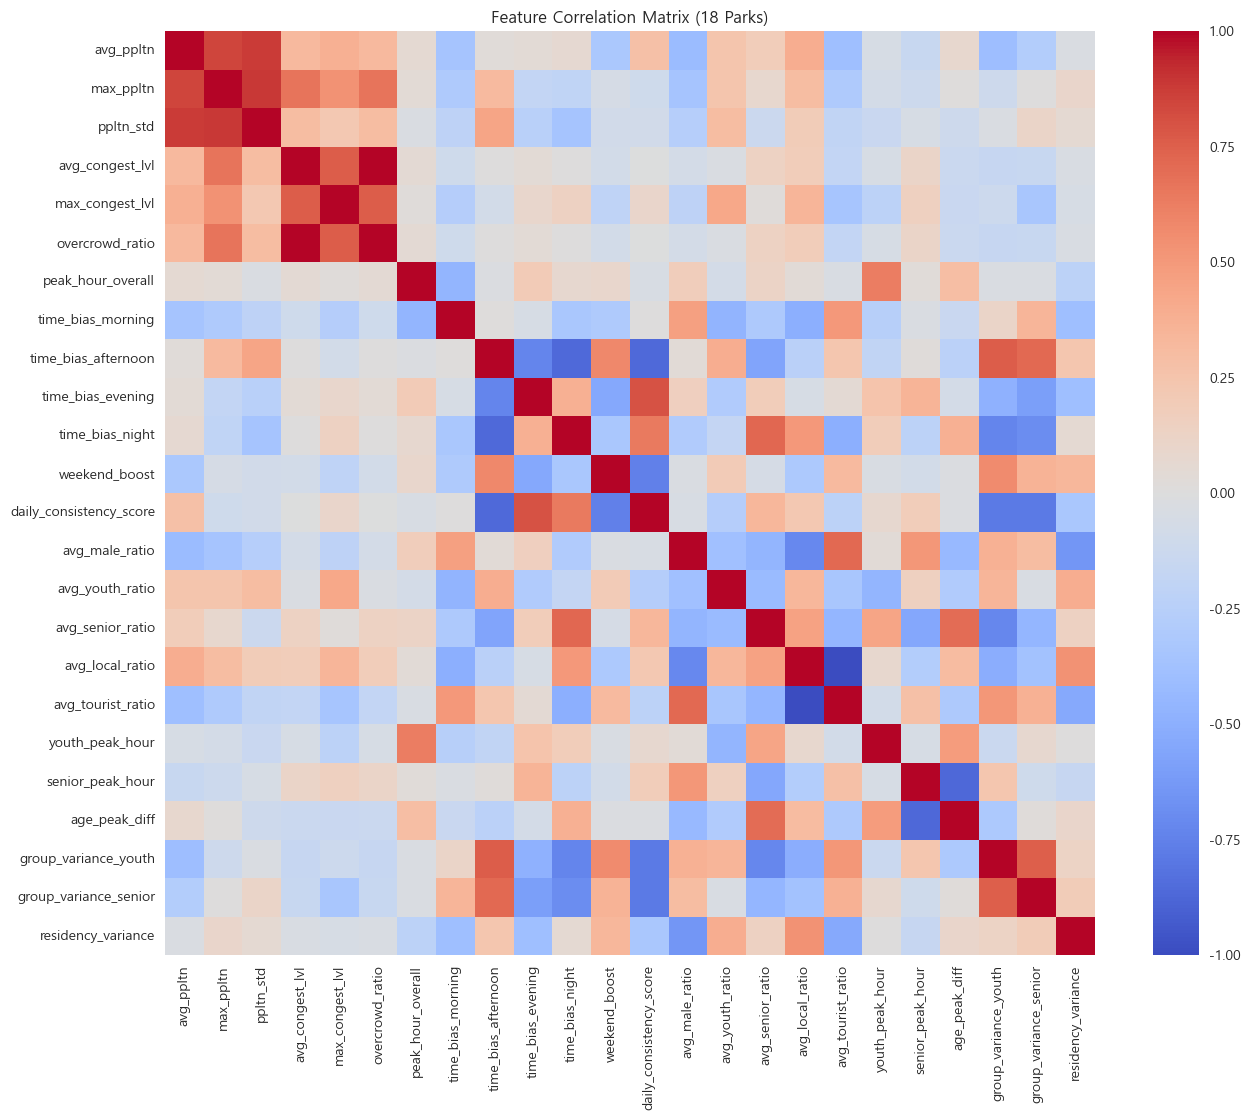

In [5]:
plt.figure(figsize=(15, 12))
sns.heatmap(X.corr(), cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Matrix (18 Parks)")
plt.show()

## 4. Optimal K Determination (Elbow & Silhouette)
Comparing various K values to confirm if K=5 is appropriate.

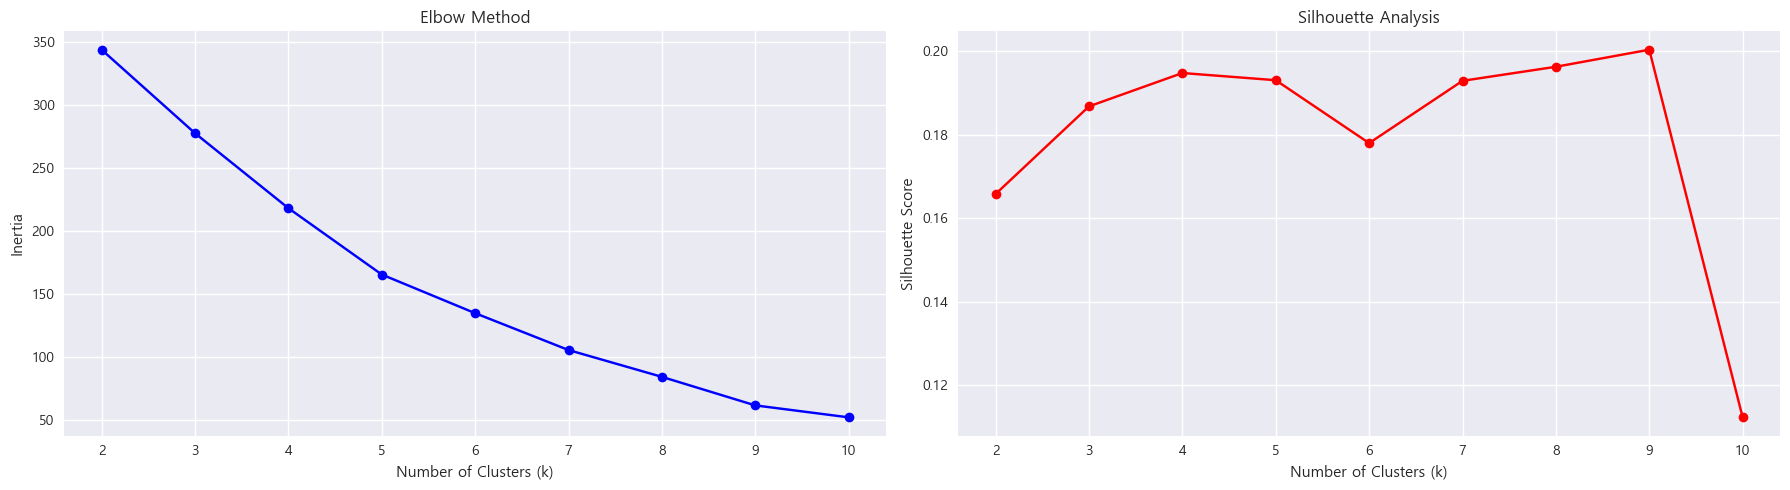


Optimal k by silhouette score: 9
Silhouette score: 0.200


In [7]:
# Determine optimal number of clusters
K_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    # calinski_scores.append(calinski_harabasz_score(X_scaled, labels))

# Plot evaluation metrics
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True)

# axes[2].plot(K_range, calinski_scores, 'go-')
# axes[2].set_xlabel('Number of Clusters (k)')
# axes[2].set_ylabel('Calinski-Harabasz Score')
# axes[2].set_title('Calinski-Harabasz Index')
# axes[2].grid(True)

plt.tight_layout()
plt.savefig('../dataset/enhanced_behavioral_clustering_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k by silhouette score: {optimal_k}")
print(f"Silhouette score: {max(silhouette_scores):.3f}")

## 5. Hierarchical Clustering Dendrogram
Visualizing the data structure to see natural groupings.

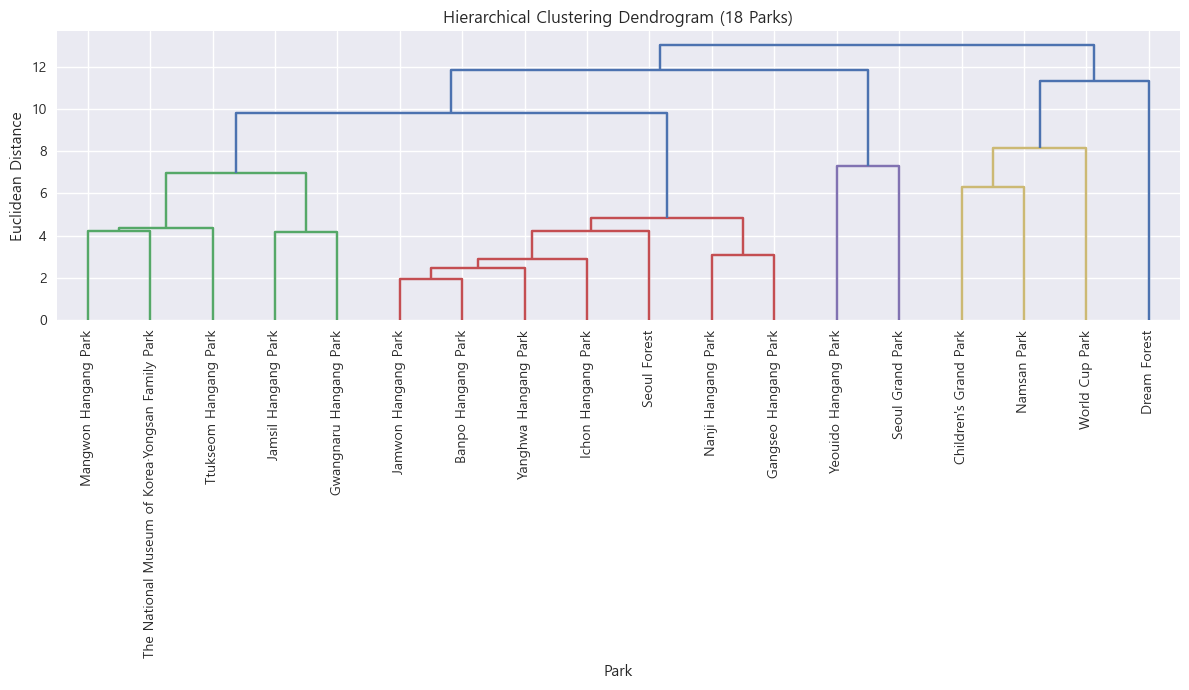

In [6]:
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 7))
dendrogram(linked,
            orientation='top',
            labels=X.index.tolist(),
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_rotation=90.,
            leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram (18 Parks)')
plt.xlabel('Park')
plt.ylabel('Euclidean Distance')
plt.tight_layout()
plt.show()

## 6. Final Clustering (K=5)
Applying K-Means with the chosen K=5.

In [10]:
# Force K=5
kmeans = KMeans(n_clusters=5, random_state=42)
X['cluster'] = kmeans.fit_predict(X_scaled)

print("Cluster Counts:")
print(X['cluster'].value_counts())

# Display Members
for c in sorted(X['cluster'].unique()):
    print(f"\n=== Cluster {c} ===")
    print(X[X['cluster'] == c].index.tolist())

Cluster Counts:
cluster
2    6
0    5
1    4
4    2
3    1
Name: count, dtype: int64

=== Cluster 0 ===
['The National Museum of Korea·Yongsan Family Park', 'Ttukseom Hangang Park', 'Mangwon Hangang Park', 'Dream Forest', "Children's Grand Park"]

=== Cluster 1 ===
['Gwangnaru Hangang Park', 'Namsan Park', 'Seoul Forest', 'Jamsil Hangang Park']

=== Cluster 2 ===
['Gangseo Hangang Park', 'Nanji Hangang Park', 'Banpo Hangang Park', 'Yanghwa Hangang Park', 'Ichon Hangang Park', 'Jamwon Hangang Park']

=== Cluster 3 ===
['World Cup Park']

=== Cluster 4 ===
['Seoul Grand Park', 'Yeouido Hangang Park']


## 7. Cluster Interpretation
Analyzing the characteristics of each cluster.

In [11]:
# Profile Summary (Mean Feature Values per Cluster)
profile = X.groupby('cluster').mean().T
print("\nCluster Profiles (Mean Values):")
display(profile.round(2))

# Save Results
X.to_csv('../interim/enhanced_behavioral_clusters.csv')
print("\nResults saved to 'interim/enhanced_behavioral_clusters.csv'")


Cluster Profiles (Mean Values):


cluster,0,1,2,3,4
avg_ppltn,2746.81,5054.92,1160.96,5871.36,1797.38
max_ppltn,6200.00,12375.00,3566.67,29000.00,12000.00
ppltn_std,556.66,1981.40,454.73,2303.64,1578.52
avg_congest_lvl,1.00,1.00,1.00,1.02,1.00
max_congest_lvl,1.60,1.00,1.00,4.00,1.00
overcrowd_ratio,0.00,0.00,0.00,0.01,0.00
peak_hour_overall,15.40,12.25,17.17,16.00,15.00
time_bias_morning,0.26,0.28,0.28,0.27,0.27
time_bias_afternoon,0.29,0.33,0.33,0.34,0.47
time_bias_evening,0.25,0.24,0.26,0.25,0.19



Results saved to 'interim/enhanced_behavioral_clusters.csv'
